# Bayesian estimation for quantum phase estimation

Many low-cost forms of quantum phase estimation require post-processing of data via a classical estimator. This tutorial details how one can use the BayesEstimator and BayesDepolarizingEstimator classes to perform this estimation.

More detailed information can be found in arXiv:1809.09697

A (single-round) QPE experiment takes the following steps:
- 1) a system register is prepared in the starting state, and an ancilla qubit is prepared in the $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ state
- 2) $U^k$ is performed conditional on the ancilla qubit.
- 3) a final rotation $e^{i\beta\sigma_z}$ is performed to the ancilla, which is then measured in the $|\pm\rangle$ basis, returning a measurement $m$.

Both $k$ (variable name: num_rotations), and $\beta$ (variable name: final_rotation) can (and should) vary between experiments.
An estimator requires data on both these, and the recorded output m (variable name: measurement) from each experiment.

In QPE, we are trying to estimate a target eigenphase $\phi_0$ of a unitary operator $U$. Let us write our Hilbert space in terms of the eigenstates of $U$ - $U|\phi_j\rangle=e^{i\phi_j}|\phi_j\rangle$. We are promised the ability to prepare a starting state $|\Psi\rangle=\sum_ja_j|\phi_j\rangle$, with $|a_j|^2=:A_j>>0$. Note that as the QPE circuit never mixes eigenstates of $U$, the only parameter that enters this problem is the norm squared $A_j$ of the amplitudes $a_j$.

The probability for measuring $m$ in any given experiment can be calculated to be
$$P_{k,\beta}(m|\vec{A},\vec{\phi})=\sum_jA_j\cos^2(k\phi_j/2+\beta/2-m\pi/2).$$

For the sake of this tutorial, rather than simulating the implementation of the QPE circuit, we can sample directly from $P$ with some randomly chosen $\phi_j$ and $A_j$ to generate data for estimation.

In [1]:
import numpy
from openfermion.measurements import BayesEstimator, BayesDepolarizingEstimator, QPERoundData, QPEExperimentData
from numpy import pi, cos, sin, exp, random
from matplotlib import pyplot as plt

In [2]:
# Toy parameters
rng = numpy.random.RandomState(seed=42)  # Chosen by Douglas Adams, guaranteed to be random
evs = rng.uniform(-pi,pi,10)
As = rng.uniform(0,1,10)
# Setting A0>>0 whilst maintaining normalization
As[1:] = As[1:] / numpy.sum(As[1:]) * 0.2
As[0] = 0.8

def model(k, beta, As, evs):
    # The probability for measuring m=0
    return numpy.dot(As, cos(evs * k / 2 + beta / 2)**2)

The BayesEstimator class take in experiments one at a time. Each experiment may take multiple rounds. We store the data for each round in the RoundData class and compile multiple rounds in one experiment into the ExperimentData class (for the sake of this tutorial let us just look at single-round experiments).

In [3]:
def do_experiment(k, beta, rng, **kwargs):
    
    p0 = model(k, beta, **kwargs)
    if p0 > rng.uniform(0, 1):
        measurement = 0
    else:
        measurement = 1
        
    data = QPERoundData(
        num_rotations=k,
        final_rotation=beta,
        measurement=measurement)
    
    return QPEExperimentData([data])

The estimator class needs to be initialized with a bit of metadata - the number of phases to estimate (num_vectors), the maximum number of rotations in a given experiment (max_n), the number of frequencies to estimate to (num_freqs), and guesses for the initial values of the amplitude (these are required in particular to break the symmetry of the problem).

In [4]:
# For efficiency, let's try to estimate two frequencies.
# The second number will most likely be garbage here.

# Trying not to cheat by guessing the true number
offset = rng.normal(0,0.1)
amplitude_guess = [0.8+offset,0.2-offset]

# Technically the covariances here should be large and negative
# but let's ignore this as the Estimator enforces that the sum
# of the amplitudes is 1.
amplitude_vars = [[2,0],[0,2]]

estimator = BayesEstimator(num_vectors=2,
                           max_n=50,
                           amplitude_guess=amplitude_guess,
                           amplitude_vars=amplitude_vars,
                           num_freqs=5000)

More optimal choices exist for the experiment design, but for simplicity we will just loop these over k=1...50 and beta=0,pi/2 (two choices of beta is essential, as cos^2(\phi/2) has two solutions in $[-\pi,\pi)$, but anything more than this doesn't seem to affect phase estimation much)

In [5]:
errors = []
for j in range(10):
    for k in range(1, 51):
        for beta in [0, pi/2]:
            experiment = do_experiment(k, beta, rng, As=As, evs=evs)
            
            # Updates the Bayesian estimation with the experiment.
            estimator.update(experiment)
            
            # Obtains the current estimation of the phase from
            # the experiment
            phase_estimate = estimator.estimate()
            amplitude_estimate = estimator.estimate_amplitudes()
            
            # We choose the phase with the corresponding largest
            # amplitude.
            index = numpy.argmax(amplitude_estimate)
            
            error = numpy.abs(evs[0] - phase_estimate[index])
            errors.append(error)

Now let us plot the error in the estimation as a function of the number of rounds. In general this will be a very noisy function, but averaging over many simulations should return the $1/\sqrt{N}$ convergence displayed in arXiv:1809.09697

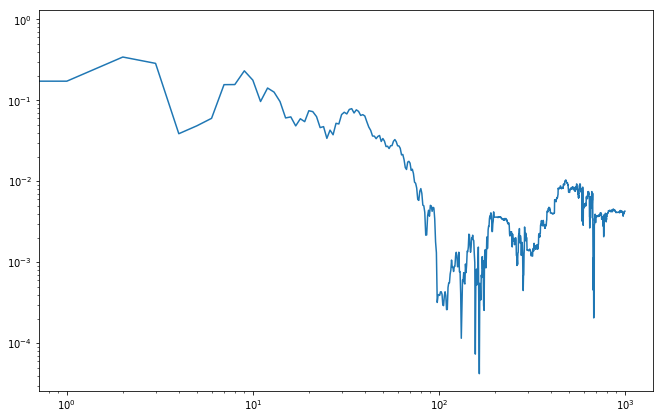

In [6]:
%matplotlib inline
plt.figure(figsize=(11,7))
plt.plot(errors)
plt.xscale('log')
plt.yscale('log')

## Depolarizing noise channel

A depolarizing noise channel is a channel where an error causes a random output. This can be simulated fairly easy with an update to $P$,
$$P(m=0)\rightarrow P(m=0)e^{-ik/K_{err}}+ 0.5(1-e^{-ik/K_{err}})$$.
The BayesDepolarizingEstimator class adds this to the Bayesian model, along with a $K_1$ parameter that models a $T_1$ process (where error causes a measurement of $0$ instead of a random output).
$$P(m=0)\rightarrow P(m=0)e^{-ik/K_{1}}+(1-e^{-ik/K_1})$$
Note that as the QPE protocol requires the ancilla qubit be rotated in the $X-Y$ plane for the majority of the experiment, and readout in most physical implementations usually rotates the qubit back along the $Z$ axis, the actual $T_1$ noise channel will not usually produce errors like this (but perhaps for some physical implementations this will be relevant).

In [7]:
Kerr=10
max_n=10
def model(k, beta, As, evs, Kerr):
    # The probability for measuring m=0
    return numpy.dot(As, cos(evs * k / 2 + beta / 2)**2) * exp(-k/Kerr) +\
        0.5 * (1 - exp(-k/Kerr))

In [8]:
#Let's compare the two estimators with this additional noise

# Trying not to cheat by guessing the true number
offset = rng.normal(0,0.1)
amplitude_guess = [0.8+offset,0.2-offset]

# Technically the covariances here should be large and negative
# but let's ignore this as the Estimator enforces that the sum
# of the amplitudes is 1.
amplitude_vars = [[2,0],[0,2]]

estimator = BayesEstimator(
    num_vectors=2,
    max_n=max_n,
    amplitude_guess=amplitude_guess,
    amplitude_vars=amplitude_vars,
    num_freqs=5000)

estimator_depol = BayesDepolarizingEstimator(
    num_vectors=2,
    max_n=max_n,
    amplitude_guess=amplitude_guess,
    amplitude_vars=amplitude_vars,
    num_freqs=5000,
    k_err=Kerr)

In [9]:
errors = []
errors_depol = []
for j in range(10):
    for k in range(1, max_n+1):
        for beta in [0, pi/2]:
            experiment = do_experiment(
                k, beta, rng, As=As, evs=evs, Kerr=Kerr)
            
            # Updates the Bayesian estimation with the experiment.
            estimator.update(experiment)
            
            # Obtains the current estimation of the phase from
            # the experiment
            phase_estimate = estimator.estimate()
            amplitude_estimate = estimator.estimate_amplitudes()
            
            # We choose the phase with the corresponding largest
            # amplitude.
            index = numpy.argmax(amplitude_estimate)
            
            error = numpy.abs(evs[0] - phase_estimate[index])
            errors.append(error)
            
            # Updates the Bayesian estimation with the experiment.
            estimator_depol.update(experiment)
            
            # Obtains the current estimation of the phase from
            # the experiment
            phase_estimate = estimator_depol.estimate()
            amplitude_estimate = estimator_depol.estimate_amplitudes()
            
            # We choose the phase with the corresponding largest
            # amplitude.
            index = numpy.argmax(amplitude_estimate)
            
            error = numpy.abs(evs[0] - phase_estimate[index])
            errors_depol.append(error)

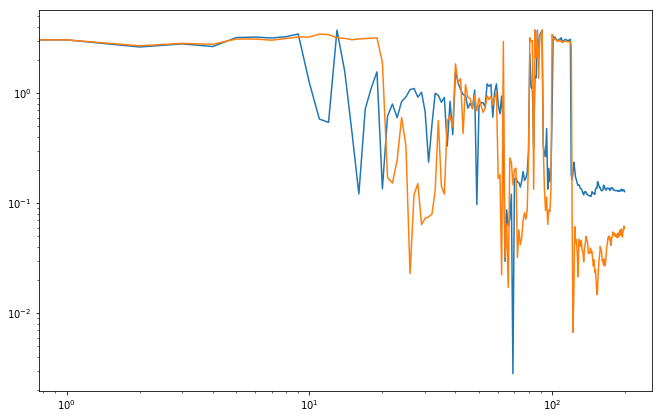

In [10]:
%matplotlib inline
plt.figure(figsize=(11,7))
plt.plot(errors)
plt.plot(errors_depol)
plt.xscale('log')
plt.yscale('log')

So this doesn't seem to show much of an improvement, although hey - factor 2 or so. This is because the Bayesian estimator seems relatively robust to depolarizing noise even if it's not built into the system, but eventually on average it becomes unstable, so the depolarizing estimator is preferable.